In [259]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification

#### Creating syntetic dataset
It has 6000 samples, 20 features and 10 classes.

In [418]:
data,target = make_classification(
    n_samples=6000,
    n_features=20,
    n_informative=10,
    n_redundant=2,
    n_repeated=0,
    n_classes=10,
    n_clusters_per_class=10,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=None,
)

#### Splitting the dataset into training, calibration and validation sets.

In [419]:
idx = np.random.permutation(target.size)
idx_train = idx[:round(idx.size*0.6)]
idx_calib = idx[round(idx.size*0.6):round(idx.size*0.8)]
idx_valid = idx[round(idx.size*0.8):]

print(f"Size of train set:{idx_train.size}\nSize of calib set:{idx_calib.size}\nSize of validation set:{idx_valid.size}\n")

Size of train set:3600
Size of calib set:1200
Size of validation set:1200



#### Fitting the model with train data

In [420]:
model = SVC(probability=True)
model.fit(data[idx_train,:],target[idx_train])

SVC(probability=True)

#### In the cell below we're creating softmax output for calibration set then sorting it in descending order and creating an array *cal_srt* with sorted values. An array *cal_pi* contains sorted indexes.

In [514]:
softmax_calib = model.predict_proba(data[idx_calib, :])
cal_pi = softmax_calib.argsort(1)[:,::-1] 
#sorts each row in descending order and returns array with indexes
cal_srt = np.take_along_axis(softmax_calib, cal_pi, axis = 1)
#returns sorted values for cal_pi indexes

#### Creating calibration scores 

In [434]:
n = target[idx_calib].size
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),target[idx_calib]]

In [499]:
alpha = 0.05
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
print(f"Qhat:{qhat}, border:{np.ceil((n+1)*(1-alpha))/n}, significance level:{(1-alpha)*100}%")

Qhat:0.39741506279818667, border:0.9508333333333333, significance level:95.0%


#### As the final step we create adaptive prediction sets. But the cherry on the cake is to use validation set,computed as cumulative, and beforehand sorted, sum of classes.

In [503]:
softmax_val = model.predict_proba(data[idx_valid, :])

val_pi = softmax_val.argsort(1)[:,::-1]
val_srt = np.take_along_axis(softmax_val,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)
prediction_sets_num = np.take_along_axis(val_srt,val_pi.argsort(axis=1),axis=1)

Text(0.5, 1.0, 'That bar, which exceeds qhat line is not included to the prediction set')

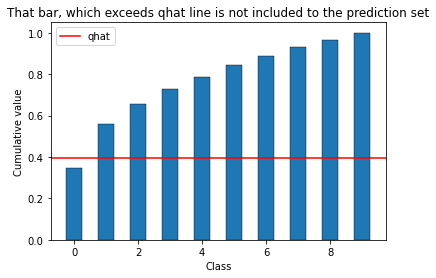

In [537]:
plt.bar(np.arange(10), val_srt[1], width=1/2, edgecolor="black", linewidth=0.4)
plt.axhline(y=qhat, color='r', linestyle='-')
plt.ylabel('Cumulative value')
plt.xlabel('Class')
plt.legend(['qhat'])
plt.title('That bar, which exceeds qhat line is not included to the prediction set')

#### *all credits to https://arxiv.org/pdf/2107.07511v5.pdf paper, by Anastasios N. Angelopoulos and Stephen Bates* 